# Ni and Fe microspectrocopy data from BNL

1. **Fe_xanes** (from HXN) is a model system sample used for optimizing nano-XANES workflow. We know the "true value" chemical state map. The aggregate is composed of 
        a. LiFe(II)PO4 (LFP)

        b. Pyrite (Pyr)

        c. StainlessSteelNP (SS) and

        d. Hematite_NP (Hem).

      *Please note that this is unpublished data from a submitted MS*


2. **Ni_xanes** is NMC?

In [1]:
from ipywidgets import IntSlider, widgets, interactive, fixed

import numpy as np
import pandas as pd
from scipy.interpolate import interp1d
from scipy.stats import wasserstein_distance, pearsonr

import sympy
import scipy

from sklearn.cluster import KMeans
from sklearn.model_selection import cross_val_score, RepeatedKFold

import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
from matplotlib import gridspec
import matplotlib as mpl

import selector
from selector import energy_point_selector
from importlib import reload

import utils
utils = reload(utils)
from utils import *

np.random.seed(42)

In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
   return false;
}

<IPython.core.display.Javascript object>

## Read in data

(101, 320, 320)
(73, 155, 160)


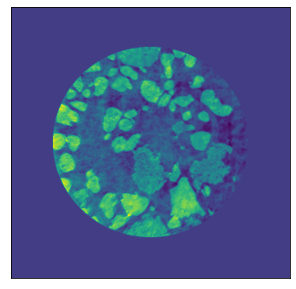

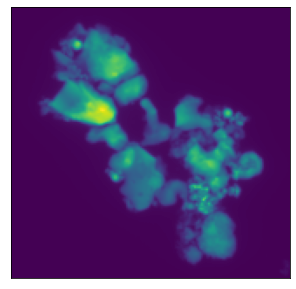

In [3]:
Ni_xanes = parse_tiff('Data/TXM_XANES/Ni_xanes.tiff')
Ni_energy = np.loadtxt('Data/TXM_XANES/Ni_eng_list.txt')

Fe_xanes = parse_tiff('Data/HXN_XANES/nanoXANES_Fe.tiff')
Fe_energy = np.loadtxt('Data/HXN_XANES/energy_list_corr.txt')

def plot_img(data):
    fig, ax = plt.subplots(figsize=(5, 5))
    ax.imshow(data, extent=[0, 1, 0, 1], aspect='auto')
    ax.set_xticks([])
    ax.set_yticks([])

print(Ni_xanes.shape)
print(Fe_xanes.shape)

plot_img(np.average(Ni_xanes, axis=0))
plot_img(np.average(Fe_xanes, axis=0))

In [4]:
expected_results = parse_tiff('Data/HXN_XANES/chemical_map.tiff')
df = pd.read_csv('Data/HXN_XANES/xanes_fit_plot.csv')
df.head()

,Data_x,Data_y,Fit_y,LiFe(II)PO4_y,Pyrite_y,StainlessSteelNP_y,Hematite_NP_y
0,7075.6,2.300333,1.244027,1.237492,-0.075648,-0.161534,0.243717
1,7081.0,2.872172,1.244027,1.237492,-0.075648,-0.161534,0.243717
2,7086.0,3.539921,1.244027,1.237492,-0.075648,-0.161534,0.243717
3,7090.8,4.428800,1.036171,1.061223,-0.085117,-0.148813,0.208878
4,7096.0,5.872788,0.033630,0.058501,-0.020770,-0.019977,0.015876


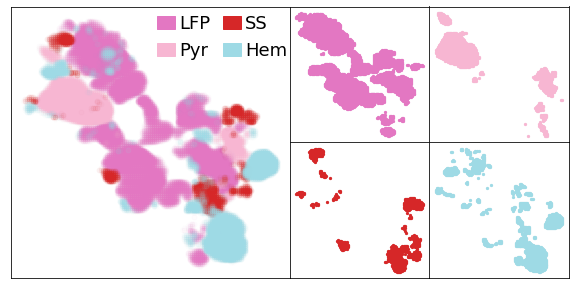

In [9]:
fig = plt.figure(figsize=(10, 5))
spec = fig.add_gridspec(nrows=2, ncols=3,
                        width_ratios=[1, 0.5, 0.5])
plt.subplots_adjust(hspace=0.0, wspace=0.0)

bigax = fig.add_subplot(spec[:2, 0])

labels = ['LFP', 'Pyr', 'SS', 'Hem']
color_labels = [12, 13, 6, 19]

for i, img in enumerate(expected_results):
    row = i // 2
    colm = i % 2 + row // 2
    ax = fig.add_subplot(spec[row, colm + 1])
    
    threshold = 0.025
    mask = np.zeros((img.shape[0], img.shape[1]))
    bool_arr = img < threshold
    mask[bool_arr] = 1
    filtered_img = np.ma.array(img, mask=mask)
    
    filtered_img_dict = {}
    for x in range(filtered_img.shape[0]):
        for y in range(filtered_img.shape[1]):
            if mask[x, y] == False:
                filtered_img_dict[(x, y)] = filtered_img[x, y]
                
    for j, key in enumerate(list(filtered_img_dict.keys())):
        x, y = key
        ax.plot(y, -x, color=plt.cm.tab20(color_labels[i]), marker='.', markersize=4.5)
    
    ax.set_xticks([])
    ax.set_yticks([])
    
plot_expected_results(expected_results, bigax)

plt.savefig('Figures/expected_results.png', dpi=400,
            transparent=True, bbox_inches='tight')

In [10]:
def plot_spectra(i, Data):
    fig, ax = plt.subplots(figsize=(5, 5))    
    data = Data[i]
    ax.imshow(data, extent=[0, 1, 0, 1], aspect='auto')
    ax.set_xticks([])
    ax.set_yticks([])
    plt.show()
        

data = Fe_xanes
slider = IntSlider(min=0, max=len(data) - 1, step=1, value=0,
                   layout=widgets.Layout(width='50%'))
interactive(plot_spectra, i=slider, Data=fixed(data))

interactive(children=(IntSlider(value=0, description='i', layout=Layout(width='50%'), max=72), Output()), _dom…

# Iron References

## Interpolating Fe XANES and Refs onto same energy grid

Pyrite - FeS2

StainlessSteelNP - Fe(0)

Maghemite - Fe(II)

LiFe(II)PO4 Fe(II)

Magnetite - Fe(II) AND Fe(III)

Goethite - FeOOH - Fe(III)

HFO – FEOOH - Fe(III)

FeIII_sulfate - Fe(III)

Fe3P - fe(III) ?

Fe(III)PO4 - Fe(III)

Hematite_NP - Fe(III)

In [5]:
ref_energy, Refs_dict_tmp, _ = parse_nor('Data/HXN_XANES/FeLibNov2021.nor')

data_columns = ['StainlessSteelNP', 'Fe3P', 'Pyrite', 'LiFe(II)PO4', 
                'Magnetite', 'FeIII_sulfate', 'Fe(III)PO4', 'Hematite_NP',
                'Maghemite', 'Goethite', 'HFO', ]

Refs_dict = {key: Refs_dict_tmp[key] for key in data_columns}
Refs_raw = np.array(list(Refs_dict.values()))

energy = np.linspace(7090, 7196, 54)

interperlator = interp1d(ref_energy, Refs_raw)
Refs = interperlator(energy)

Fe_xanes_tmp = np.zeros((len(energy), Fe_xanes.shape[1], Fe_xanes.shape[2]))
for x in range(Fe_xanes.shape[1]):
    for y in range(Fe_xanes.shape[2]):
        interperlator = interp1d(Fe_energy, Fe_xanes[:, x, y])
        Fe_xanes_tmp[:, x, y] = interperlator(energy)

Fe_xanes = Fe_xanes_tmp
Fe_energy = energy

(12, 196)


# Some visualization

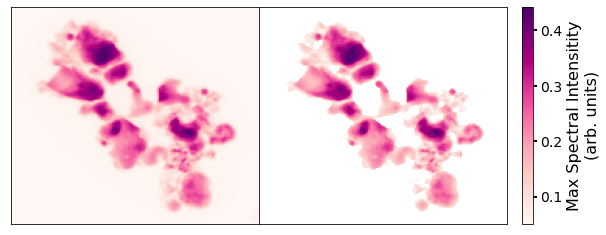

In [12]:
data = Fe_xanes

fig = plt.figure(figsize=(10, 4))
spec = fig.add_gridspec(ncols=2, width_ratios=[0.8, 1.])
plt.subplots_adjust(wspace=0.)

cmap = plt.cm.RdPu
ax = fig.add_subplot(spec[0])
ax.imshow(np.max(data, axis=0), extent=[0, 1, 0, 1], aspect='auto', cmap=cmap)
ax = fig.add_subplot(spec[1])
img = ax.imshow(np.max(get_filtered_img(data), axis=0), extent=[0, 1, 0, 1],
                aspect='auto', cmap=cmap)

for ax in fig.get_axes():
    remove_ticks(ax)

cbar = plt.colorbar(img, ax=ax)
cbar.ax.tick_params(width=2, length=4, labelsize=14)
cbar.ax.set_ylabel('Max Spectral Intensitity\n(arb. units)', fontsize=16)
plt.savefig('Figures/two-dim_heatmap.png', dpi=400,
            transparent=True, bbox_inches='tight')

In [13]:
%matplotlib inline

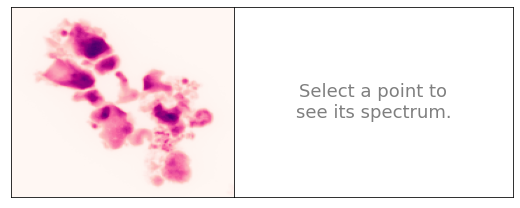

In [14]:
data = Fe_xanes

fig = plt.figure(figsize=(9, 3.5))
spec = fig.add_gridspec(ncols=2, width_ratios=[0.8, 1.])
plt.subplots_adjust(wspace=0.)

ax = fig.add_subplot(spec[0])
img = ax.imshow(np.max(data, axis=0), extent=[0, 1, 0, 1], aspect='auto',
                cmap=plt.cm.RdPu)

ax = fig.add_subplot(spec[1])
ax.text(0.5, 0.5, "Select a point to\nsee its spectrum.", fontsize=18, ha='center', va='center',
        c=plt.cm.tab10(7))

for ax in fig.get_axes():
    remove_ticks(ax)

add_point_label(img, data, ax)

# Step 1. Filter out background, i.e., space with no sample

In [6]:
data = Fe_xanes
energy = Fe_energy

fd, mask = get_filtered_img(data, return_mask=True)

filtered_spectra_dict = {}
for x in range(fd.shape[1]):
    for y in range(fd.shape[2]):
        if mask[0, x, y] == False:
            spectrum = fd[:, x, y]
            filtered_spectra_dict[(x, y)] = spectrum
filtered_spectra = np.array(list(filtered_spectra_dict.values()))

# Step 2. Normalize experimental spectra

In [7]:
utils = reload(utils)
from utils import *

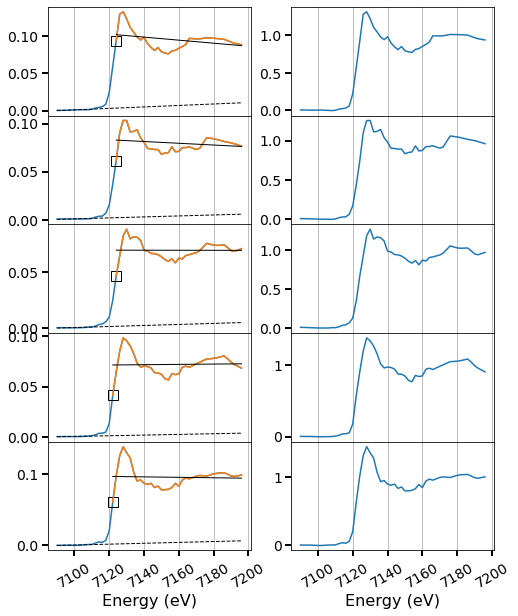

In [8]:
pre_edge, post_edge, whitelines = show_normalization(energy, filtered_spectra, N=5, return_params=True,
                                                     plot=True, pre_edge_offset=5)

In [9]:
normalized_spectra, normalized_spectra_dict = normalize_spectra(energy,
                                                                filtered_spectra,
                                                                filtered_spectra_dict)

In [10]:
# Renormalize references
Refs, Refs_dict = normalize_spectra(energy, Refs, Refs_dict)
Refs = np.array(Refs)
Refs.shape

(11, 54)

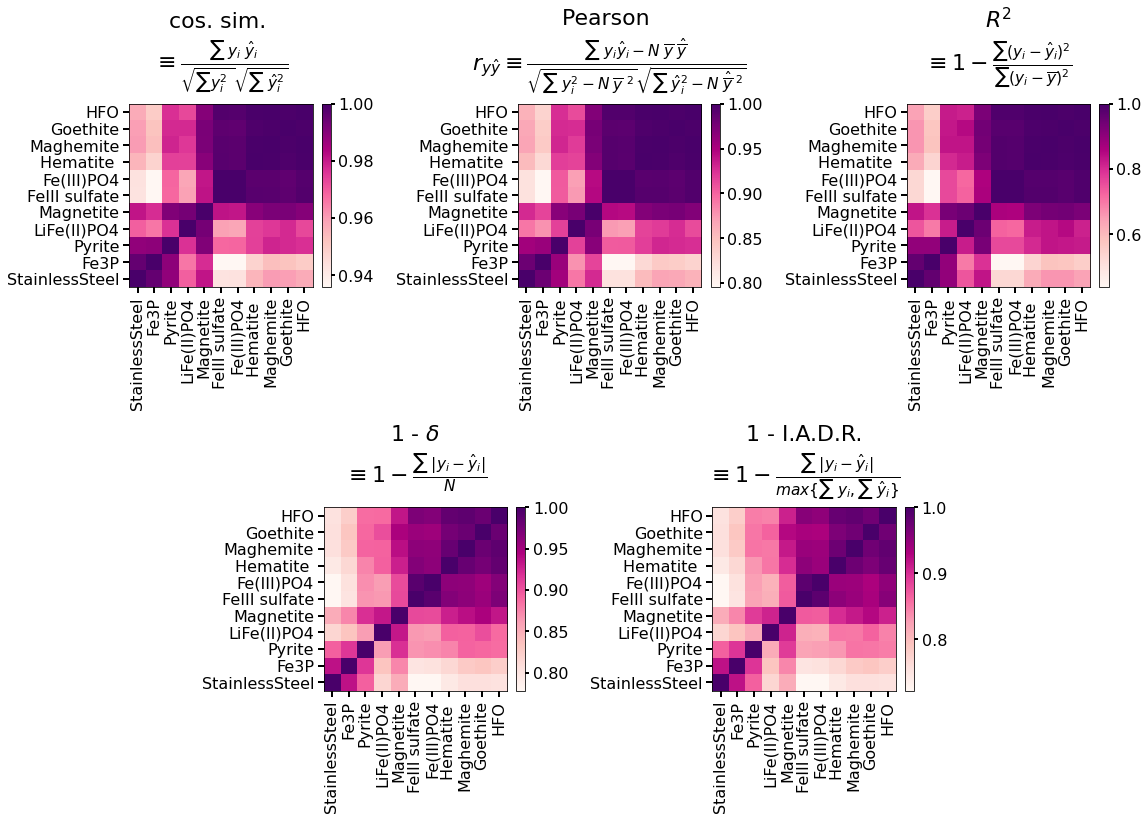

In [21]:
metrics = ['cosine similarity', 'Pearson correlation', '$R^2$', '1 - $\delta$', '1 - IADR']

fig = plt.figure(figsize=(3 * 6, 5.4 * 2))
spec = fig.add_gridspec(ncols=6, nrows=2)
plt.subplots_adjust(wspace=5., hspace=1.2)
plots = [spec[0, :2], spec[0, 2:4], spec[0, 4:], spec[1, 1:3], spec[1, 3:5]]
axes = [fig.add_subplot(plot) for plot in plots]

for i, metric in enumerate(metrics):
    Similarity_matrix = get_similarity_mtx(Refs, metric=metric)
    plot_corr_matx(axes[i], Similarity_matrix, data_columns, metric)
    if i in [3, 4]:
        y = 1.1
    else:
        y = 1.15
    axes[i].set_title(axes[i].get_title(), fontsize=22, y=y)
    
plt.savefig('Figures/similarity_matrices.png', dpi=400, transparent=False, bbox_inches='tight')

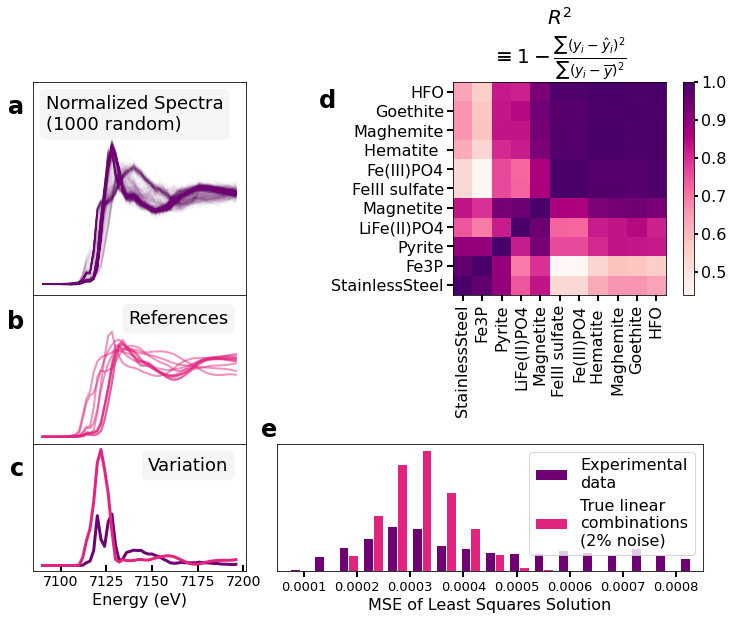

In [30]:
fig = plt.figure(figsize=(12, 9))
spec = fig.add_gridspec(nrows=3, ncols=2,
                        height_ratios=[1, 0.7, 0.6], width_ratios=[0.5, 1])
plt.subplots_adjust(hspace=0., wspace=0.1)
axes = []
for i in range(3):
    tmp = [fig.add_subplot(spec[i, j]) for j in range(2)]
    axes.append(tmp)
    
colors = [plt.cm.RdPu(0.9), plt.cm.PuRd(0.65)]
w = (.95, .95, .95, 0.7)
white_bbox = dict(boxstyle="round", ec=w, fc=w)

c = 0
N = 1000
tmp_X = []
for i in range(len(filtered_spectra)):
    mod = 2
    x = normalized_spectra[mod * i]
    if np.min(x) > -0.01: 
        tmp_X.append(x)
        axes[0][0].plot(energy, normalized_spectra[mod * i], linewidth=1.5, alpha=0.01,
                        color=colors[0])
        c += 1
    if c > N:
        tmp_X = np.array(tmp_X)
        axes[0][0].plot(energy[0], [2.1], '.', c='w', alpha=0)
        break

axes[2][0].plot(energy, np.var(tmp_X, axis=0), linewidth=3, c=colors[0])

for i, r in enumerate(Refs):
    axes[1][0].plot(energy, r, linewidth=2, alpha=0.5, color=colors[1])
axes[1][0].plot(energy[0], [1.85], '.', c='w', alpha=0)

axes[2][0].plot(energy, np.var(Refs, axis=0), linewidth=3, c=colors[1])

labels = [f'Normalized Spectra\n({N} random)', 'References', 'Variation']

panels = ['a', 'b', 'c', 'd', 'e']
for i, ax_list in enumerate(axes):
    for j, ax in enumerate(ax_list):
        if j == 0:
            if i == 0:
                y = 0.94
                ax.text(0.06, y, labels[i], transform=ax.transAxes, fontsize=18, va='top', ha='left',
                        bbox=white_bbox)
            else:
                y = 0.9
                ax.text(0.92, y, labels[i], transform=ax.transAxes, fontsize=18, va='top', ha='right',
                        bbox=white_bbox)
            ax.tick_params(direction='in', width=2, length=6, labelsize=14)
            ax.set_yticks([])
            if i != 2:
                ax.set_xticks([])
            else:
                ax.set_xlabel('Energy (eV)', fontsize=16)
            ax.text(-0.04, y, panels[i], transform=ax.transAxes, fontweight='bold',
                    fontsize=24, va='top', ha='right')
        elif (i, j)  == (0, 1):
            ax.text(-0.55, 0.97, panels[3], transform=ax.transAxes, fontweight='bold',
                    fontsize=24, va='top', ha='right')
        elif (i, j)  == (2, 1):
            ax.text(0.0, 1.2, panels[4], transform=ax.transAxes, fontweight='bold',
                    fontsize=24, va='top', ha='right')

metric = '$R^2$'
Similarity_matrix = get_similarity_mtx(Refs, metric=metric)
plot_corr_matx(axes[0][1], Similarity_matrix, data_columns, metric)

axes[1][1].axis('off')
plot_MSE_hist(axes[2][1], tmp_X, Refs, bins=60, colors=colors)
plt.savefig('Figures/Data_vs_Refs.png', dpi=600, bbox_inches='tight', transparent=True)

In [23]:
residuals = []
data = tmp_X
for i in range(len(data)):
    print(i, end='\r')
    A = Refs.T
    y = data[i]
    x = np.linalg.pinv(A.T @ A) @ A.T @ y

    fit = A @ x
    true = y
    residuals.append(A @ x - y)

residuals = np.array(residuals)

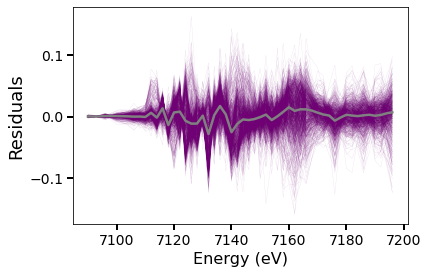

In [24]:
fig, ax = plt.subplots(figsize=(6, 4))
plt.subplots_adjust(wspace=0, hspace=0)
for r in residuals:
    ax.plot(energy, r, color=colors[0], linewidth=0.2, alpha=0.2)

ax.plot(energy, np.average(residuals, axis=0), linewidth=2.5, color='gray')
    
ax.set_xlabel('Energy (eV)', fontsize=16)
ax.set_ylabel('Residuals', fontsize=18)
ax.tick_params(width=2, length=6, labelsize=14)
plt.savefig('Figures/residuals.png', dpi=600, bbox_inches='tight')

# Step 3. Cluster Spectra
# PIPELINE: PCA --> UMAP --> dbscan --> clustering

0 -> 12
3 -> 13
1 -> 6
2 -> 19


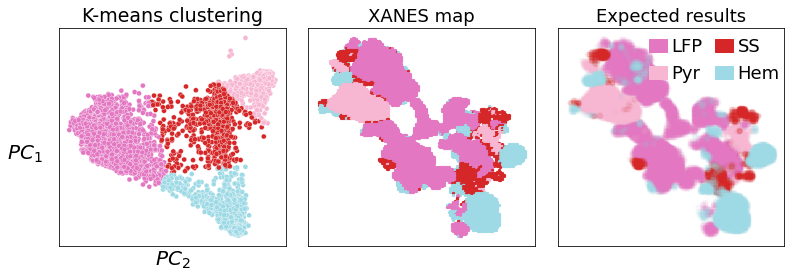

In [25]:
pca = PCA(n_components=2)
pca_components = pca.fit_transform(normalized_spectra)

reduced_space = pca_components
spectra_dict = normalized_spectra_dict

clustering = KMeans(n_clusters=4, random_state=42).fit(reduced_space)
cluster_dict = {loc: clustering.labels_[i] for i, loc in enumerate(list(spectra_dict.keys()))}
color_labels, codemap = get_translated_colors(clustering, spectra_dict, map_colors=True,
                                              translation=1)
colors = [plt.cm.tab20(c) for c in color_labels]

fig, axes = plt.subplots(figsize=(13, 4), ncols=3)
plt.subplots_adjust(wspace=0.1)

ax = axes[0]
ax.scatter(reduced_space[:, 0], reduced_space[:, 1], marker='o', s=25, color=colors,
           edgecolor='w', linewidth=0.3)

ax.set_ylabel(f'$PC_1$', fontsize=20, loc="center", rotation="horizontal")
ax.yaxis.set_label_coords(-0.15, 0.37)
ax.set_xlabel(f'$PC_2$', fontsize=20)
ax.set_xticks([])
ax.set_yticks([])
ax.set_title('K-means clustering', fontsize=19)

plot_color_code_map((fig, axes[1]), normalized_spectra_dict, color_labels)
axes[1].set_title('XANES map', fontsize=18)

plot_expected_results(expected_results, axes[2])
axes[2].set_title('Expected results', fontsize=18)
plt.savefig('Figures/PCA_kmeans_results.png', dpi=600, bbox_inches='tight')

In [64]:
utils = reload(utils)
from utils import *

1 -> 12
4 -> 13
3 -> 6
0 -> 7
2 -> 19


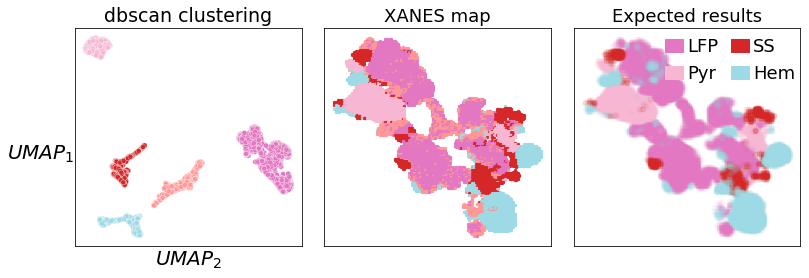

In [65]:
pca = PCA(n_components=6)
pca_components = pca.fit_transform(normalized_spectra)
spectra_dict = normalized_spectra_dict

reducer = umap.UMAP(random_state=42, n_components=2,
                    n_neighbors=80, min_dist=0)
reduced_space = reducer.fit_transform(pca_components)

eps = 1
clustering = DBSCAN(eps=eps, min_samples=1).fit(reduced_space)
cluster_dict = {loc: clustering.labels_[i] for i, loc in enumerate(list(spectra_dict.keys()))}
color_labels, codemap = get_translated_colors(clustering, spectra_dict, map_colors=True,
                                              translation=2)
colors = [plt.cm.tab20(c) for c in color_labels]

fig, axes = plt.subplots(figsize=(13, 4), ncols=3)
plt.subplots_adjust(wspace=0.1)

ax = axes[0]
ax.scatter(reduced_space[:, 0], reduced_space[:, 1], marker='o', s=25, color=colors,
           edgecolor='w', linewidth=0.3)

ax.set_ylabel(f'$UMAP_1$', fontsize=20, loc="center", rotation="horizontal")
ax.yaxis.set_label_coords(-0.15, 0.37)
ax.set_xlabel(f'$UMAP_2$', fontsize=20)
ax.set_xticks([])
ax.set_yticks([])
ax.set_title('dbscan clustering', fontsize=19)

plot_color_code_map((fig, axes[1]), normalized_spectra_dict, color_labels)
axes[1].set_title('XANES map', fontsize=18)

plot_expected_results(expected_results, axes[2])
axes[2].set_title('Expected results', fontsize=18)

plt.savefig('Figures/UMAP_2D_results.png', dpi=600, bbox_inches='tight')

In [74]:
utils = reload(utils)
from utils import *

It takes 9 PCs to explain
97% variance.
1 -> 12
4 -> 13
3 -> 6
0 -> 7
2 -> 19


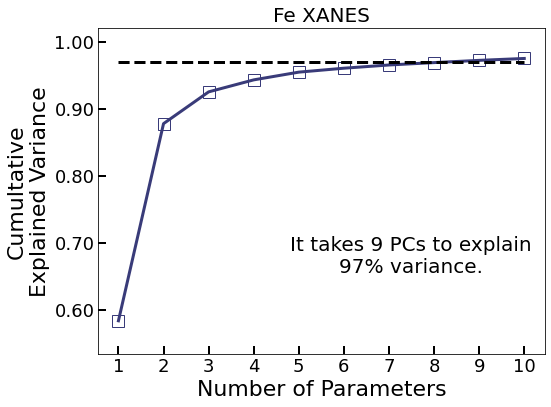

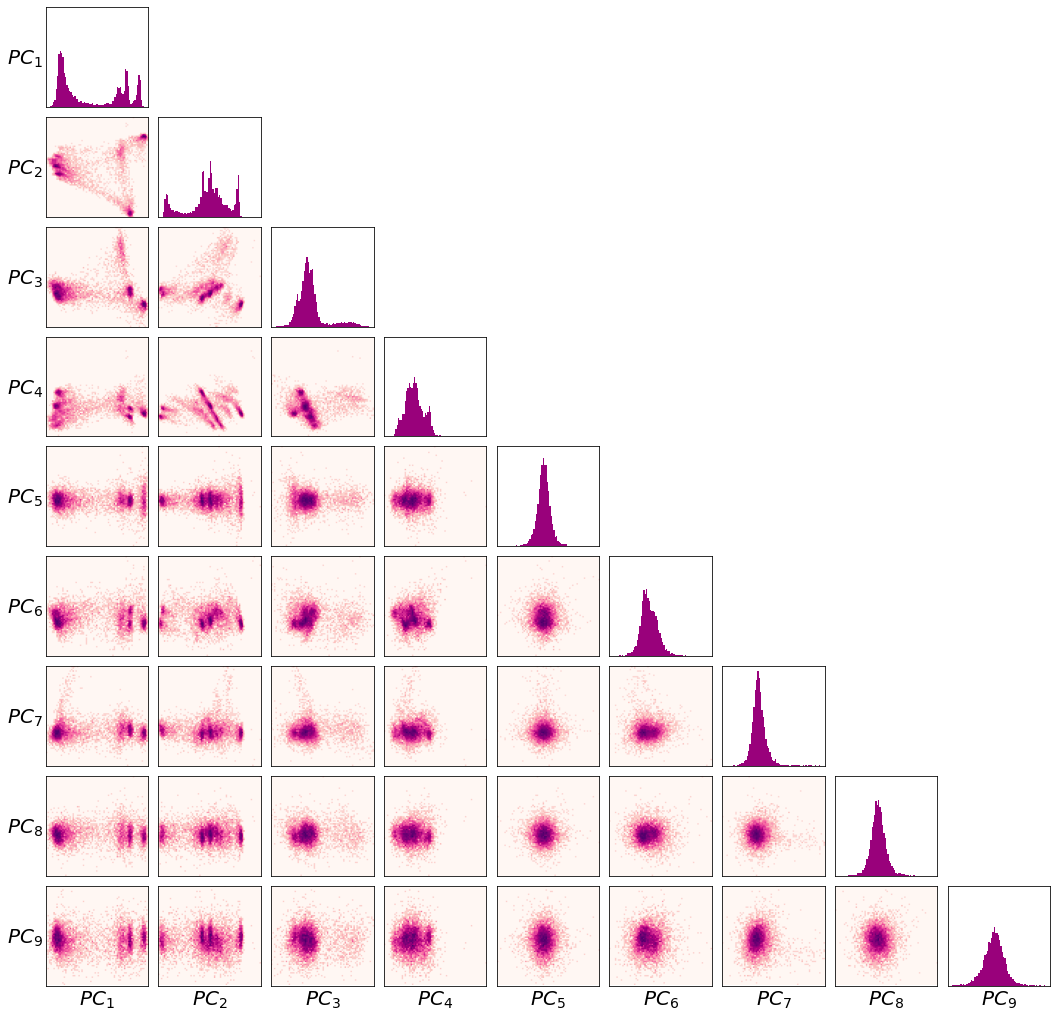

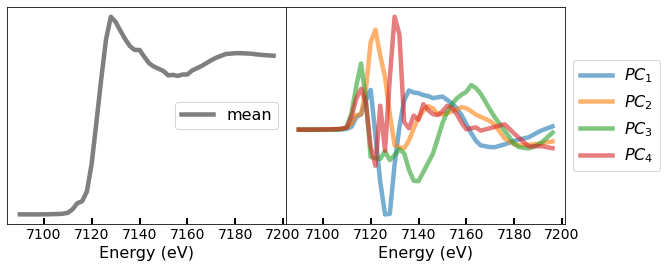

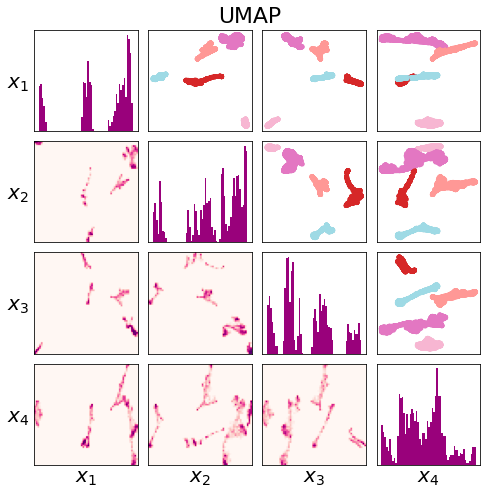

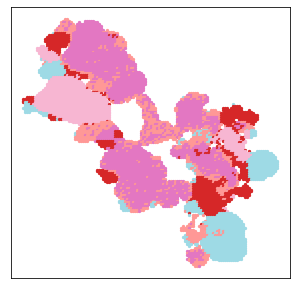

In [75]:
# PCA
n_components = make_scree_plot(normalized_spectra, n=10, c=0, threshold=0.97, show_first_PC=False)
plt.title('Fe XANES', fontsize=20)
plt.savefig('Figures/full_spectra_scree.png', dpi=600, bbox_inches='tight')

pca, pca_components = make_PCA_triangle_plot(normalized_spectra, n_components, bins=70,
                                             cmap=plt.cm.RdPu, c=plt.cm.RdPu(0.8))
plt.savefig('Figures/full_spectra_PCA_traingle_plot.png', dpi=600, bbox_inches='tight')

show_PCs(energy, pca, n=4)
plt.savefig('Figures/full_spectra_first_PCs.png', dpi=600, bbox_inches='tight')

# UMAP & dbscan
color_labels, codemap, dbscan_clustering = make_UMAP_plot(pca_components, normalized_spectra_dict, eps=1.0,
                                                          n_neighbors=30, min_dist=0, dimension=4, bins=60,
                                                          cmap=plt.cm.RdPu, c=plt.cm.RdPu(0.8),
                                                          translation=2)
plt.savefig('Figures/full_spectra_UMAP.png', dpi=600, bbox_inches='tight')

# Final clusters
plot_color_code_map(plt.subplots(figsize=(5, 5)), normalized_spectra_dict, color_labels)
plt.savefig('Figures/full_spectra_cluster_map.png', dpi=600, bbox_inches='tight')

In [76]:
print(len(np.unique(dbscan_clustering.labels_)), len(np.unique(color_labels)))

5 5


# Step 4. LCF

### First find cluster averages

In [77]:
exp_data = np.array(normalized_spectra)
indices = np.arange(len(exp_data))
n_reps = 5000
sims = []
metric = '$R^2$'
for i in range(n_reps):
    rand_idxs = np.random.choice(indices, size=2, replace=False)
    similarity = evaluate_similarity(exp_data[rand_idxs[0]],
                                     exp_data[rand_idxs[1]],
                                     metric)
    sims.append(similarity)
sims = np.array(sims)
print(np.average(sims), np.std(sims))

0.9021048323186571 0.07674038483727837


In [78]:
cluster_avgs = get_cluster_avgs(normalized_spectra_dict, color_labels, dbscan_clustering)
avg_spectra = np.array(list(cluster_avgs.values()))

total_avg = np.average(avg_spectra, axis=0)
diversity = np.sum((avg_spectra - total_avg)**2) / np.sum(total_avg)
print("Diversity of UMAP clusters:")
print(diversity)

cluster_sizes = []
for label in np.unique(dbscan_clustering.labels_):
    count = np.sum([1 for l in dbscan_clustering.labels_ if l == label])
    cluster_sizes.append(count)
cluster_sizes = np.array(cluster_sizes)

random_diversities = []
for k in range(100):
    print(k, end='\r')
    Is = []
    indices = list(np.arange(np.sum(cluster_sizes)))
    for cluster in cluster_sizes:
        selection = np.random.choice(indices, size=cluster, replace=False)
        Is.append(selection)
        indices = [i for i in indices if i not in selection]

    cluster_avgs_random = []
    for j, label in enumerate(np.unique(dbscan_clustering.labels_)):
        spectra = np.array([normalized_spectra[i] for i in Is[j]])
        cluster_avgs_random.append(np.average(spectra, axis=0))
    cluster_avgs_random = np.array(cluster_avgs_random)

    total_avg_random = np.average(cluster_avgs_random, axis=0)
    diversity_random = np.sum((cluster_avgs_random - total_avg_random)**2) / np.sum(total_avg_random)
    random_diversities.append(diversity_random)
random_diversities = np.array(random_diversities)

print("\nDiversity of random clusters:")
xbar = np.average(random_diversities)
s = np.std(random_diversities)
print(f'{xbar} +/- {s}')  # sample mean and std

"""
H0: Diversity from UMAP is not statistically significant compared to random groupings.

H1: Diversity from UMAP is statistically significant compared to random groupings.

We will be doing a z test with significance (alpha) = 0.01
"""

z = (diversity - xbar) / s
pval = scipy.stats.norm.sf(z)
print(f"p-val = {pval}")
alpha = 0.01
if pval < alpha:
    print("We reject the null hypothesis, so the diversity of the UMAP clusters is statisitcally significant.")
else:
    print("We cannot reject the null hypothesis, so the diversity of the UMAP clusters " +
          "is not statisitcally significant.")

Diversity of UMAP clusters:
0.060980893208844394
99
Diversity of random clusters:
4.4107527761187545e-05 +/- 1.9201408567527678e-05
p-val = 0.0
We reject the null hypothesis, so the diversity of the UMAP clusters is statisitcally significant.


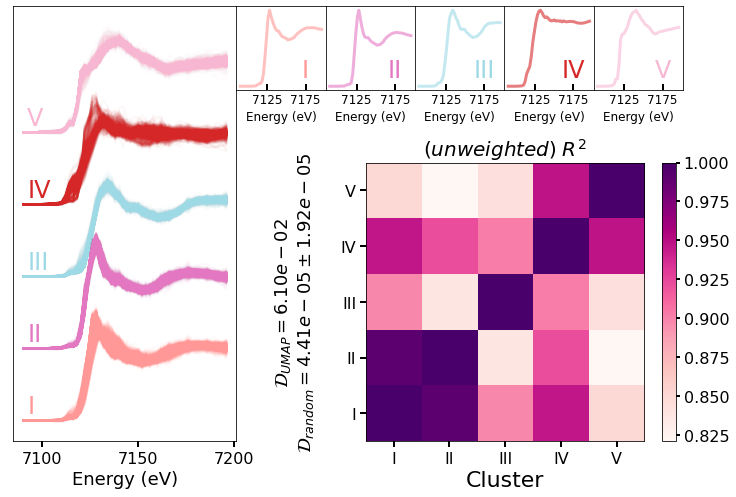

In [79]:
n_clusters = len(avg_spectra)
labels = ['I', 'II', 'III', 'IV', 'V']

fig = plt.figure(figsize=(12, 8))
width_ratios = np.ones(1 + n_clusters)
width_ratios[1:] = width_ratios[1:] / 2.5

spec = fig.add_gridspec(nrows=2, ncols=1 + n_clusters,
                        height_ratios=[0.3, 1.], width_ratios=width_ratios)
plt.subplots_adjust(hspace=0.4, wspace=0.)
subplts = [fig.add_subplot(spec[:, 0]), fig.add_subplot(spec[1, 1:])]
axes = [fig.add_subplot(spec[0, 1 + i]) for i in range(n_clusters)]
   
plot_spaghetti_by_cluster(subplts[0], energy, normalized_spectra, avg_spectra,
                          color_labels, labels, codemap)
plot_cluster_avgs((fig, axes), energy, cluster_avgs, codemap, linewidth=3)

metric = '$R^2$'
sim_matrix = get_similarity_mtx(avg_spectra, metric=metric)
metric = '$(unweighted) \; R^2$'
plot_corr_matx(subplts[1], sim_matrix, labels, metric, rot=0)

ylabel = '$\mathcal{D}_{UMAP} = ' + f'{diversity:.2e}$\n'
ylabel += '$\mathcal{D}_{random} = ' + f'{xbar:.2e} \pm {s:.2e}$\n'
subplts[1].set_ylabel(ylabel, fontsize=18)
subplts[1].set_xlabel('Cluster', fontsize=22)

plt.savefig('Figures/full_spectra_cluster_averages.png', dpi=600, bbox_inches='tight')

## How reliable are Refs fitted onto themselves?

In [80]:
utils = reload(utils)
from utils import *

It takes 4 PCs to explain
98% variance.


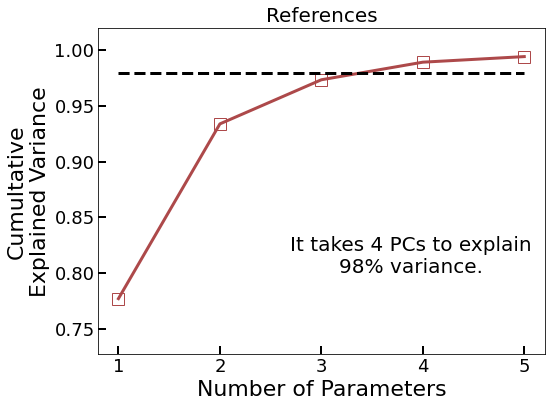

In [81]:
make_scree_plot(Refs, threshold=.98, show_first_PC=False, c=13)
plt.title('References', fontsize=20)
plt.savefig('Figures/refs_scree.png', dpi=400, bbox_inches='tight')

In [83]:
subset_size = 3
subset_indices, subsets, scales, coeffs, scores = [], [], [], [], []
targets = Refs 
for i in range(len(targets)):
    sub_idxs, subset, scale, coeffs_hat, score = LCF(targets[i], targets, subset_size,
                                                     lambda1=0.1, lambda2=1e8)
    subset_indices.append(sub_idxs)
    subsets.append(subset)
    coeffs.append(coeffs_hat)
    scales.append(scale)
    scores.append(score)

Best score less than 1e-16
[0 5 6] 0.0
[1 2 4] 2.080794390035834e-05
[2 3 7] 6.271233032872914e-08
[3 4 9] 1.534274686187942e-07
[4 7 9] 5.247270693509165e-07
[2 3 5] 4.922218251879329e-07
[ 3  6 10] 1.2473551969094387e-06
[2 7 9] 2.896590289847012e-07
[1 2 8] 2.009050951268243e-06
[0 5 9] 1.5040563527968231e-07
[ 2  7 10] 3.3317672465393855e-07


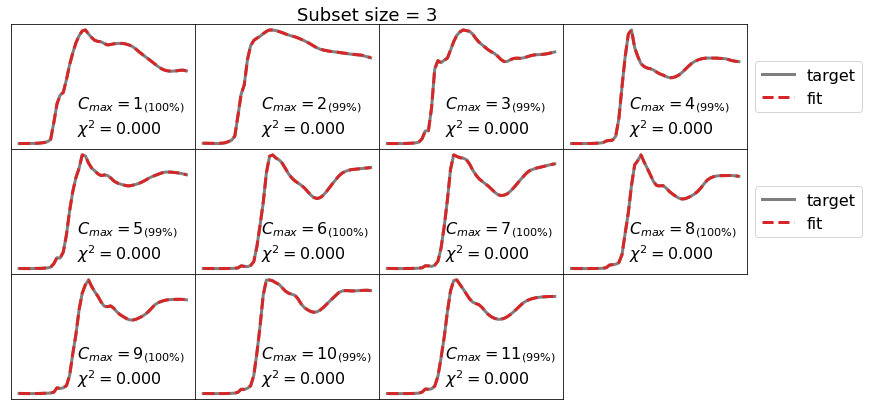

In [84]:
plot_recon_grid(energy, targets, subset_indices, subsets, scales, coeffs, Refs_dict,
                verbose=True, ncols=4, c=3)              
plt.suptitle(f'Subset size = {subset_size}', fontsize=18, y=.88, va='bottom')
plt.show()

# LCF algorithm 
Test case to demonstrate flags

In [11]:
subset_size = 3
lambda1 = 0.5
lambda2 = 1e8
keys = ['subset_indices', 'subset', 'scale', 'coeffs', 'score']

real_coeffs = [[0.5, 0.5], [0.25, 0.75], [0.1, 0.9]]
real_indices = [[0, 3], [0, 4], [1, 2]]
targets = [real_coeffs[0][0] * Refs[real_indices[0][0]] + \
               real_coeffs[0][1] * Refs[real_indices[0][1]],
           real_coeffs[1][0] * Refs[real_indices[1][0]] + \
               real_coeffs[1][1] * Refs[real_indices[1][1]],
           real_coeffs[2][0] * Refs[real_indices[2][0]] + \
               real_coeffs[2][1] * Refs[real_indices[2][1]]]

basis = Refs[:5]

top_n = 3

Results = []
for i in range(len(targets)):
    target = targets[i]
    top_picks = {}
    best_subset_indices, best_scores = LCF(target, basis, subset_size, reps=top_n,
                                           lambda1=lambda1, lambda2=lambda2,
                                           verbose=True)
    for j, indices in enumerate(best_subset_indices):
        subset, scale, coeffs_hat = get_fit_params_from_indices(indices, basis, target,
                                                                lambda1=lambda1, lambda2=lambda2)
        score = best_scores[j]
        top_picks[j + 1] = {keys[0]: indices, keys[1]: subset, keys[2]: scale,
                            keys[3]: coeffs_hat, keys[4]: score}
    
    Results.append(top_picks)       

[0 2 3] 7.133516854995747e-08
[0 3 4] 2.917263297597117e-08
[1 2 3] 1.589838827253942e-07


In [24]:
from sklearn.linear_model import MultiTaskElasticNetCV

In [92]:
basis = Refs

kwargs = {'N': 500, 'scale': 0.0, 'dropout': 0.8}
train_x, train_y = generate_linear_combos(basis, **kwargs)
kwargs = {'N': 10, 'scale': 0.0, 'dropout': 0.8}
test_x, test_y = generate_linear_combos(basis, **kwargs)

In [93]:
cv = RepeatedKFold(n_splits=5, n_repeats=50, random_state=42)
model = MultiTaskElasticNetCV(cv=cv, random_state=42, max_iter=8000)
model.fit(train_x, train_y)

MultiTaskElasticNetCV(cv=RepeatedKFold(n_repeats=50, n_splits=5, random_state=42),
                      max_iter=8000, random_state=42)

In [94]:
model.alpha_, model.l1_ratio_

(0.0001356735693751666, 0.5)

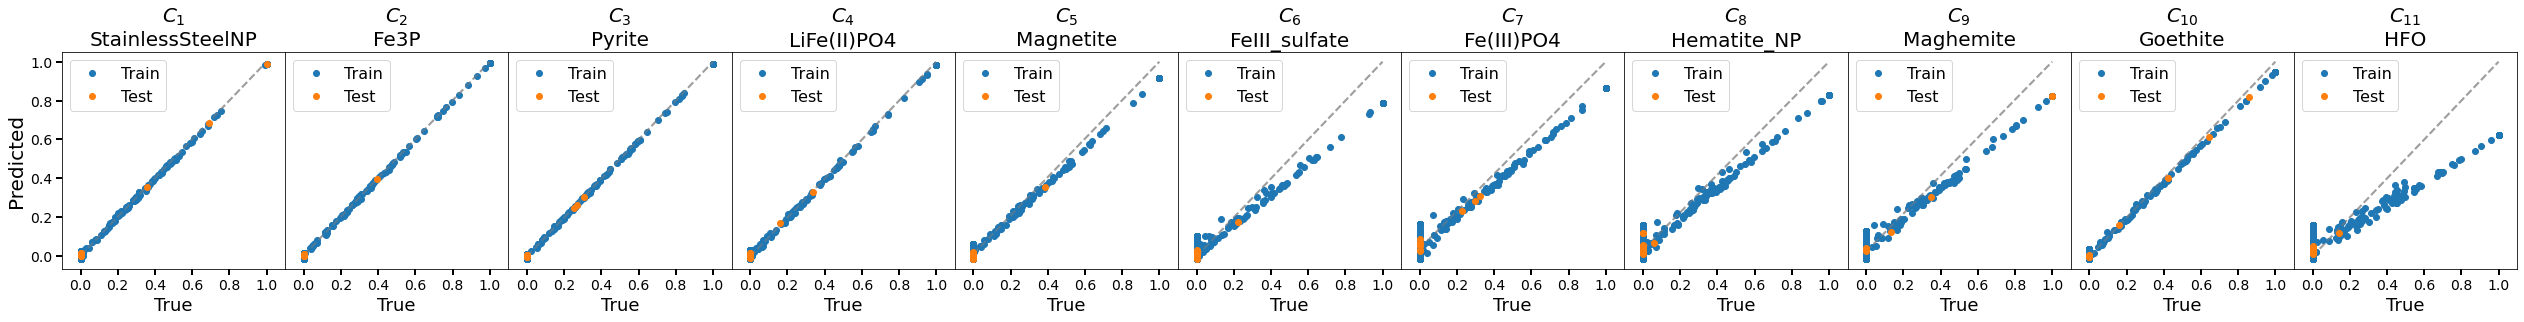

In [98]:
labels = ['Train', 'Test']
titles = ['$C_{' + f'{i + 1}' + '}$\n' + f'{data_columns[i]}' for i in range(len(basis))]
i = 0
ncols = len(basis)
fig, axes = plt.subplots(figsize=(4 * ncols, 4), ncols=ncols)
plt.subplots_adjust(wspace=0.)
for x, y in [[train_x, train_y], [test_x, test_y]]:
    y_pred = model.predict(x)
    for j, ax in enumerate(axes):
        ax.plot([0, 1], [0, 1], '--', c=plt.cm.tab10(7), alpha=0.5, linewidth=2)
        ax.plot(y[:, j], y_pred[:, j], 'o', c=plt.cm.tab10(i), label=labels[i])
        ax.legend(fontsize=16)
        ax.tick_params(labelsize=14, width=2, length=6, direction='out')
        ax.set_xlim(-0.1, 1.1)
        ax.set_xticks(np.linspace(0, 1, 6))
        if j != 0:
            ax.set_yticks([])
        else:
            ax.set_yticks(np.linspace(0, 1, 6))
            ax.set_ylabel('Predicted', fontsize=20)
        ax.set_title(titles[j], fontsize=20)
        ax.set_xlabel('True', fontsize=18)
    i += 1

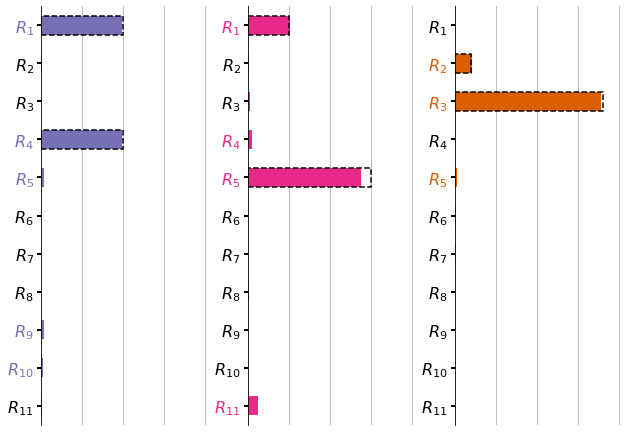

In [96]:
pred_coeffs = model.predict(targets)
indices = np.arange(len(basis))

N = len(basis)
labels = ['$R_{' + f'{N - c}' + '}$' for c in range(N)]
colors = [plt.cm.Dark2(c) for c in [2, 3, 1]]
n_targets = len(targets)
fig, axes = plt.subplots(figsize=(3.5 * n_targets, 0.7 * N ),
                         ncols=n_targets)
plt.subplots_adjust(wspace=0.2, hspace=0.7)

for i, ax in enumerate(axes):
    format_bar_axes(ax, N, labels)
    
    #indices = [k for k in range(len(pred_coeffs[i]))
    #           if pred_coeffs[i, k] > 0.01]
    #for k, tick in enumerate(ax.yaxis.get_ticklabels()):
    #    if k in N - 1 - indices:
    #        tick.set_color(colors[i])
    
    for k, tick in enumerate(ax.yaxis.get_ticklabels()):
        if pred_coeffs[i, N - 1 - k] > 0.01:
            tick.set_color(colors[i])
    
    ax.barh(N - 1 - indices, pred_coeffs[i], height=0.5,
            color=colors[i], alpha=1, zorder=2)
    ax.barh(N - 1 - np.array(real_indices[i]), real_coeffs[i], height=0.5,
            edgecolor='k', fill=False, linewidth=1.5, linestyle='--', zorder=2)

In [89]:
utils = reload(utils)
from utils import *

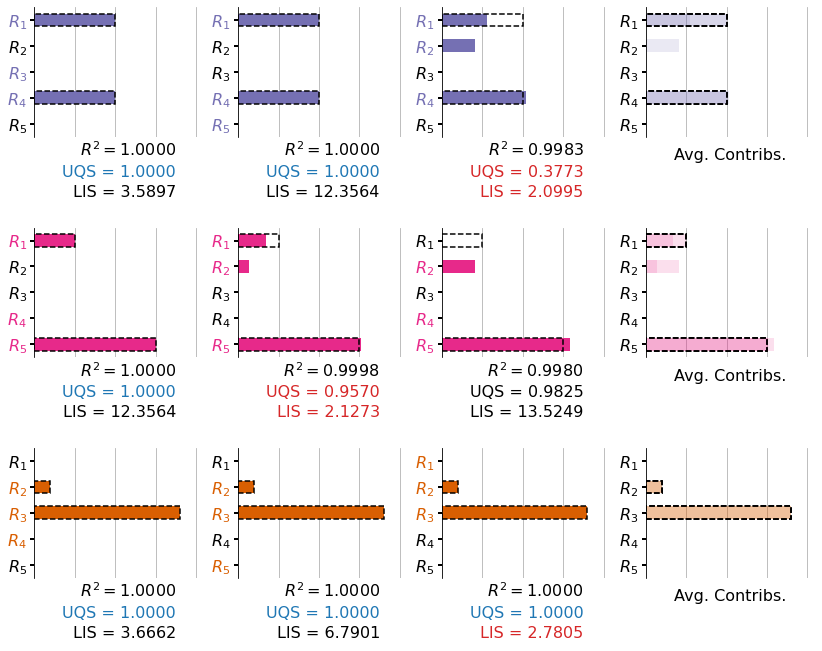

In [13]:
N = len(basis)
labels = ['$R_{' + f'{N - c}' + '}$' for c in range(N)]
colors = [plt.cm.Dark2(c) for c in [2, 3, 1]]
n_targets = len(targets)

lind_thresh = 3
unq_thresh = 0.96

fig, axes_list = plt.subplots(figsize=(3.5 * (top_n + 1), 0.7 * N * n_targets),
                              ncols=top_n + 1, nrows=n_targets)
plt.subplots_adjust(wspace=0.2, hspace=0.7)


for i in range(n_targets):    
    axes = axes_list[i]
    top_picks = Results[i]
    
    best_coeffs = top_picks[1][keys[3]][0]
    best_subset = top_picks[1][keys[1]]
    best_sorted_coeffs, best_sorted_subset = sort_by_x(best_coeffs, best_subset)
    
    best_contribs = np.array([best_sorted_coeffs[j] * best_sorted_subset[j]
                              for j in range(subset_size)])
    
    for j, ax in enumerate(axes):
        format_bar_axes(ax, N, labels)
    
    for j in range(top_n):
        indices = top_picks[j + 1][keys[0]]
        subset = top_picks[j + 1][keys[1]]
        coeffs = top_picks[j + 1][keys[3]][0]
        score = top_picks[j + 1][keys[4]]
        
        xlabel = '$R^2 = ' + f'{1 - score:.4f}$'
        text_colors = ['k' for k in range(subset_size)]       
        
        unq = get_uniqueness_cost(coeffs, subset, best_contribs, subset_size)
        unq_label = f'\nUQS = {unq:.4f}'
        
        if unq < unq_thresh:
            text_colors[1] = plt.cm.tab10(3)
        elif unq > .999999:
            text_colors[1] = plt.cm.tab10(0)

        #lind = 1 - np.max([r2_score(ri, rj) for ri, rj in itertools.combinations(subset, 2)])
        combos = np.array([[ri, rj] for ri, rj in itertools.combinations(subset, 2)])
        lind = -r2_score(combos[:, 1, :], combos[:, 0, :], multioutput='variance_weighted')
        lind_label = f'\nLIS = {lind:.4f}'
            
        if lind < lind_thresh:
            text_colors[2] = plt.cm.tab10(3)
            
        add_multicolored_xlabel(axes[j], [xlabel, unq_label, lind_label], text_colors)
            
        
        for k, tick in enumerate(axes[j].yaxis.get_ticklabels()):
            if k in N - 1 - indices:
                tick.set_color(colors[i]) 

        for idx in [j, top_n]:
            if idx == j:
                alpha = 1
                
            else:
                alpha = 0.15
            
            axes[idx].barh(N - 1 - indices, coeffs, height=0.5,
                           color=colors[i], alpha=alpha, zorder=2)
            axes[idx].barh(N - 1 - np.array(real_indices[i]), real_coeffs[i], height=0.5,
                           edgecolor='k', fill=False, linewidth=1.5, linestyle='--', zorder=2)
    
    axes[top_n].set_xlabel('Avg. Contribs.', fontsize=16)    
               
plt.savefig('Figures/test_flag_LCF.png', dpi=600, bbox_inches='tight')

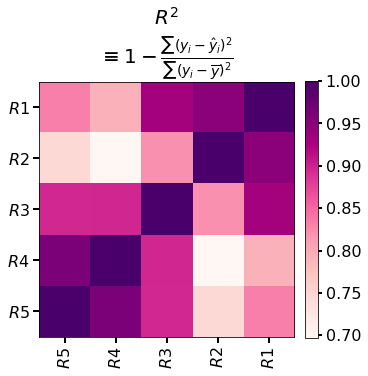

In [64]:
fig, ax = plt.subplots(figsize=(5, 5))
Similarity_matrix = get_similarity_mtx(basis, metric='$R^2$')
plot_corr_matx(ax, Similarity_matrix, labels, '$R^2$')

## Cluster averages fit to Refs

In [47]:
subset_size = 3
lambda1 = 0.5
lambda2 = 1e8
keys = ['subset_indices', 'subset', 'scale', 'coeffs', 'score']

basis = Refs
targets = np.array(list(cluster_avgs.values()))
top_n = 3

Results = []
for i in range(len(targets)):
    target = targets[i]
    top_picks = {}
    best_subset_indices, best_scores = LCF(target, basis, subset_size, reps=top_n,
                                           lambda1=lambda1, lambda2=lambda2,
                                           verbose=True)
    for j, indices in enumerate(best_subset_indices):
        subset, scale, coeffs_hat = get_fit_params_from_indices(indices, basis, target,
                                                                lambda1=lambda1, lambda2=lambda2)
        score = best_scores[j]
        top_picks[j + 1] = {keys[0]: indices, keys[1]: subset, keys[2]: scale,
                            keys[3]: coeffs_hat, keys[4]: score}
    
    Results.append(top_picks)       

NameError: name 'cluster_avgs' is not defined

In [85]:
subset_size = 3
subset_indices, subsets, scales, coeffs, scores = [], [], [], [], []
targets = np.array(list(cluster_avgs.values()))
for i in range(len(targets)):
    sub_idxs, subset, scale, coeffs_hat, score = LCF(targets[i], Refs, subset_size,
                                                     lambda1=1, lambda2=1e8)
    subset_indices.append(sub_idxs)
    subsets.append(subset)
    scales.append(scale)
    coeffs.append(coeffs_hat)
    scores.append(score)

[0 3 7] 0.001700364936540466
[3 7 8] 0.004318830452025413
[ 2  7 10] 0.0003622415202514384
[0 3 6] 0.00367174945076032
[0 2 7] 0.0009659737799815327


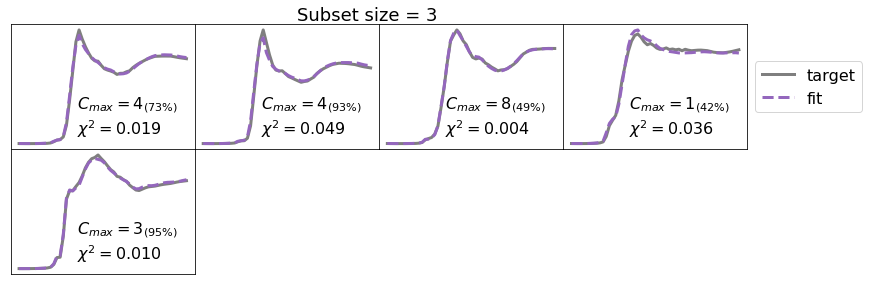

In [86]:
plot_recon_grid(energy, targets, subset_indices, subsets, scales, coeffs, Refs_dict,
                ncols=5, flag_identity=False, c=4)              
plt.suptitle(f'Subset size = {subset_size}', fontsize=18, y=.88, va='bottom')
plt.show()

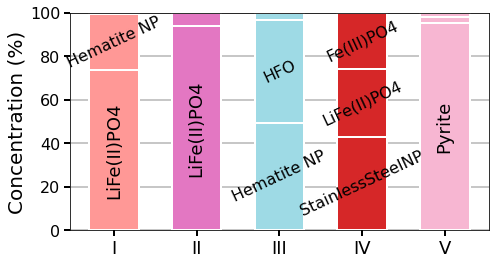

In [87]:
fig, ax = plt.subplots(figsize=(len(cluster_avgs) * 1.5, 4))
plot_conc_from_subset((fig, ax), np.array(coeffs).reshape(len(coeffs), -1),
                      list(Refs_dict.keys()), subset_indices, codemap)
plt.savefig('Figures/full_spectra_cluster_concentrations.png', dpi=600, bbox_inches='tight')

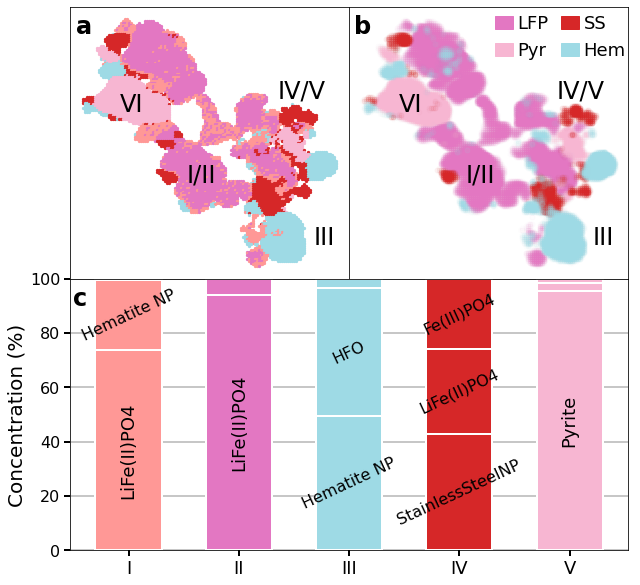

In [88]:
fig = plt.figure(figsize=(10, 10))
spec = fig.add_gridspec(nrows=2, ncols=2)
axes = [fig.add_subplot(spec[0, 0]), fig.add_subplot(spec[0, 1]),
        fig.add_subplot(spec[1, :])]
plt.subplots_adjust(hspace=0.0, wspace=0.0)

plot_color_code_map((fig, axes[0]), normalized_spectra_dict, color_labels)

plot_expected_results(expected_results, axes[1])

plot_conc_from_subset((fig, axes[2]), np.array(coeffs).reshape(len(coeffs), -1),
                      list(Refs_dict.keys()), subset_indices, codemap)

panels = ['a', 'b', 'c']
for i, ax in enumerate(axes):
    if i == 2:
        x = 0.03
    else:
        x = 0.08
    ax.text(x, 0.97, panels[i], transform=ax.transAxes, fontweight='bold',
            fontsize=24, va='top', ha='right')
    
points = [(0.22, 0.64), (0.47, 0.38), (0.91, 0.15), (0.83, 0.69)]
labels = ['V', 'I/II', 'III', 'IV']
for ax in axes[:2]:
    for i, pt in enumerate(points):
        x, y = pt
        ax.text(x, y, labels[i], transform=ax.transAxes,
                fontsize=24, va='center', ha='center')

plt.savefig('Figures/full_spectrum_results.png', dpi=600,
            transparent=True, bbox_inches='tight')

# PART II. Recursive Feature Elimination

In [11]:
energy_point_selector = reload(selector.energy_point_selector)

In [116]:
base_estimator = 'Linear Regression'

best_n = 25
Is = []

reps = 30
for i in range(reps):
    print(i, end='\r')
    kwargs = {'N': 300, 'scale': 0.0, 'dropout': 0.8}
    data, coeffs = generate_linear_combos(Refs, **kwargs)
    
    select = energy_point_selector.Selector(data, coeffs)
    rfe = select.select_energy_points(estimator=base_estimator, n_points=best_n,
                                      verbose=False, scoring='r2')
    energy_measurements = energy[rfe.support_]
    indices = [i for i, e in enumerate(energy) if e in energy_measurements]
    Is.append(indices)
Is = np.array(Is)

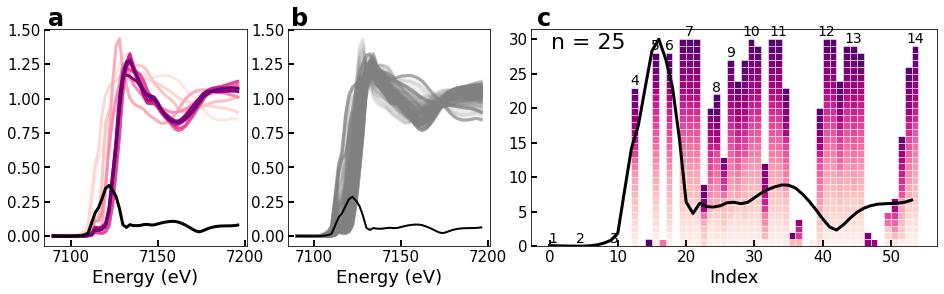

In [120]:
fig = plt.figure(figsize=(16, 4))
spec = fig.add_gridspec(ncols=3, width_ratios=[0.5, 0.5, 1.0])
plt.subplots_adjust(wspace=0.15)
axes = [fig.add_subplot(spec[j]) for j in range(3)]

indices = [0, 4, 9, 12, 15, 17, 20, 24, 26, 29, 33, 40, 44, 53]
#[12, 15, 17, 20, 24, 27, 29, 33, 40, 43, 45, 53]
n_refs = len(Refs)
colors = [plt.cm.RdPu((i + 1) / (n_refs + 1)) for i in range(n_refs)]
plot_RFE_results(axes, energy, Refs, indices, Is, best_n, colors,
                 leg=False, loc=2, **kwargs)

labels = ['a', 'b', 'c']
for i, ax in enumerate(axes):
    if i == 2:
        x = 0.05
        ax.set_xlabel('Index', fontsize=18)
    else:
        x = 0.1
        ax.set_xlabel('Energy (eV)', fontsize=18)
    ax.text(x, 1.1, labels[i], transform=ax.transAxes, fontweight='bold',
            fontsize=24, va='top', ha='right')

plt.savefig('Figures/RFE_results_Refs.png', dpi=600, bbox_inches='tight')

# RFE on a random sampling of experimental spectra

In [12]:
basis = np.array([x for i, x in enumerate(normalized_spectra) if i % 200 == 0])
print(basis.shape)

(34, 54)


In [15]:
best_estimator = 'Linear Regression'
best_n = 25
Is = []
kwargs = {'N': 2000, 'scale': 0.0, 'dropout': 0.985}

reps = 50
for i in range(reps):
    print(i, end='\r')
    data, coeffs = generate_linear_combos(basis, **kwargs)
    
    select = energy_point_selector.Selector(data, coeffs)
    rfe = select.select_energy_points(estimator=best_estimator, n_points=best_n,
                                      verbose=False, scoring='r2')
    energy_measurements = energy[rfe.support_]
    indices = [i for i, e in enumerate(energy) if e in energy_measurements]
    Is.append(indices)
Is = np.array(Is)

In [ ]:
fig = plt.figure(figsize=(16, 4))
spec = fig.add_gridspec(ncols=3, width_ratios=[0.5, 0.5, 1.0])
plt.subplots_adjust(wspace=0.15)
axes = [fig.add_subplot(spec[j]) for j in range(3)]

indices = [0, 4, 9, 12, 15, 17, 20, 24, 26, 29, 33, 40, 44, 53]
colors = [plt.cm.RdPu(i / len(basis)) for i in range(len(basis))]
plot_RFE_results(axes, energy, basis, indices, Is, best_n, colors,
                 leg=False, loc=3, **kwargs)

labels = ['a', 'b', 'c']
for i, ax in enumerate(axes):
    if i == 2:
        x = 0.05
        ax.set_xlabel('Index', fontsize=18)
    else:
        x = 0.1
        ax.set_xlabel('Energy (eV)', fontsize=18)
    ax.text(x, 1.1, labels[i], transform=ax.transAxes, fontweight='bold',
            fontsize=24, va='top', ha='right')
axes[2].set_ylim(0, axes[2].get_ylim()[1] * 1.1)

plt.savefig('Figures/RFE_results_rand_sample_exp_data.png', dpi=600, bbox_inches='tight')

# Back to the pipeline on energy subset
## Step 1. Slice energies

In [93]:
utils = reload(utils)
from utils import *

In [94]:
indices = [0, 4, 9, 12, 15, 17, 20, 24, 26, 29, 33, 40, 44, 53]
energy_subset = np.array(energy[indices])
Y_Refs = Refs[:, indices]

prenormalized_subset = np.array(normalized_spectra)[:, indices]

data_subset = np.array(filtered_spectra)[:, indices]
postnormalized_subset, postnormalized_subset_dict = normalize_spectra(energy_subset,
                                                                      data_subset,
                                                                      filtered_spectra_dict,
                                                                      pre_edge_offset=2)

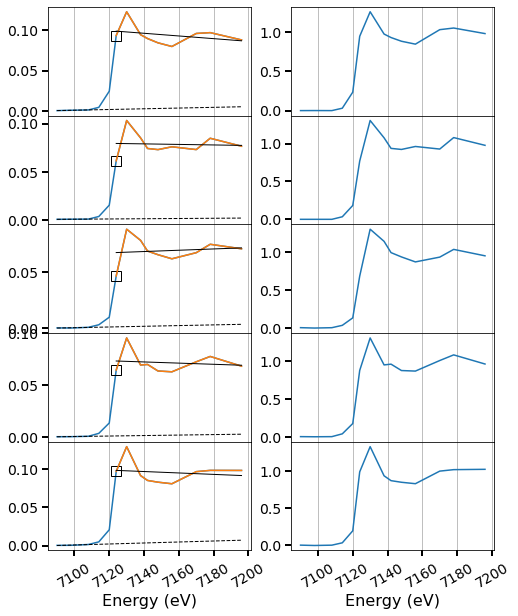

In [95]:
sub_slopes, sub_intercepts, sub_whitelines = show_normalization(energy_subset, data_subset,
                                                                N=5, return_params=True,
                                                                pre_edge_offset=2)

ValueError: x has 54 columns but y has 14 columns

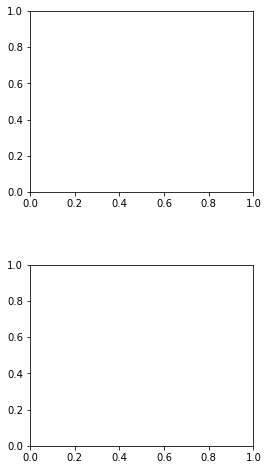

In [96]:
N = 100
slopes, intercepts, whitelines = show_normalization(energy, filtered_spectra,
                                                    N=N, return_params=True, plot=False)
sub_slopes, sub_intercepts, sub_whitelines = show_normalization(energy_subset, data_subset,
                                                                N=N, return_params=True, plot=False)

fig, axes = plt.subplots(figsize=(4, 8), nrows=2)
plt.subplots_adjust(hspace=0.4)

def plot_corr(x1, x2, ax):
    ax.plot(x1, x2, 'o', markersize=7)

    reg = LinearRegression().fit(x1.reshape(-1, 1), x2.reshape(-1, 1))
    y_fit = reg.predict(x1.reshape(-1, 1)).reshape(-1)
    ax.plot(x1, y_fit, '-')

    x = np.linspace(min(x1), max(x1), 10)
    #ax.plot(x, x, '--', c='k')
    
    R, pval = pearsonr(x1, x2)
    ax.text(0.08, 0.88, f'$R={R:.3f}$', transform=ax.transAxes, fontsize=18)

plot_corr(slopes, sub_slopes, axes[0])
plot_corr(intercepts, sub_intercepts, axes[1])

variables = ['slope', 'intercept']
for i, ax in enumerate(axes):
    ax.set_ylabel(f'Subset {variables[i]}', fontsize=18)
    ax.set_xlabel(f'Full {variables[i]}', fontsize=18)
    ax.tick_params(direction='in', width=2, length=8, labelsize=16)

In [97]:
def plot_params(ax, energy, params, color, scale=1, dy=0):
    pre, post, whiteline = params
    ax.plot(energy, pre / scale - dy, '--', c=color)
    ax.plot(energy[whiteline:], post / scale - dy, c=color)
    ax.plot(energy[whiteline], post[0] / scale - dy, 's', fillstyle='none',
             linewidth=3, markersize=10, c=color)
    
def get_scale_dy(spectrum):
    alpha = np.max(spectrum)
    dy = np.min(spectrum / alpha)
    return alpha, dy

In [98]:
N = 100

full_energy = energy.copy()
full_spectra = filtered_spectra.copy()
pre_edge_fits, post_edge_fits, whitelines = show_normalization(full_energy, full_spectra, N=N, start_i=0,
                                                               pre_edge_offset=15, return_params=True, plot=False)
sub_pre_edge_fits, sub_post_edge_fits, sub_whitelines = show_normalization(energy_subset, data_subset, N=N, start_i=0,
                                                                           pre_edge_offset='none', return_params=True,
                                                                           plot=False)

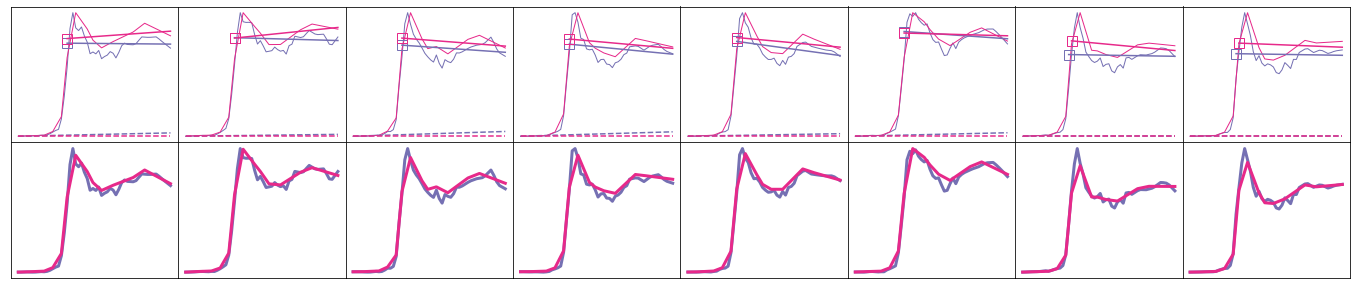

In [99]:
N = 8

fig, axes = plt.subplots(figsize=(3 * N, 5), ncols=N, nrows=2)
plt.subplots_adjust(wspace=0, hspace=0)

colors = [plt.cm.Dark2(i) for i in [2, 3]]

R2s = []
for idx in range(N):
    xs = []
    for j, params in enumerate([[pre_edge_fits[idx], post_edge_fits[idx], whitelines[idx]],
                                [sub_pre_edge_fits[idx], sub_post_edge_fits[idx], sub_whitelines[idx]]]):
        
        pre, post, whiteline = params
        
        if j == 0:
            energy = full_energy
            spectrum = full_spectra[idx]
        else:
            energy = energy_subset
            pre = np.ones(len(energy)) * pre[0]            
            spectrum = data_subset[idx]
               
        scale, dy = get_scale_dy(spectrum)
        params = pre, post, whiteline
        plot_params(axes[0, idx], energy, params, colors[j], scale=scale, dy=dy)
        
        axes[0, idx].plot(energy, spectrum / scale - dy, c=colors[j], linewidth=1, zorder=1)
        
        y_norm = normalize_spectrum(energy, spectrum, verbose=False,
                                    whiteline=whiteline, y_fit_pre=pre, y_fit_post=post)

        axes[1, idx].plot(energy, y_norm, linestyle='-', c=colors[j], linewidth=3)        

    for ax in axes[:, idx]:
        ax.set_yticks([])
        ax.set_xticks([])

## Step 2. Clustering pipeline

It takes 7 PCs to explain
99% variance.
5 -> 13
4 -> 2
3 -> 6
1 -> 0
0 -> 12
2 -> 19


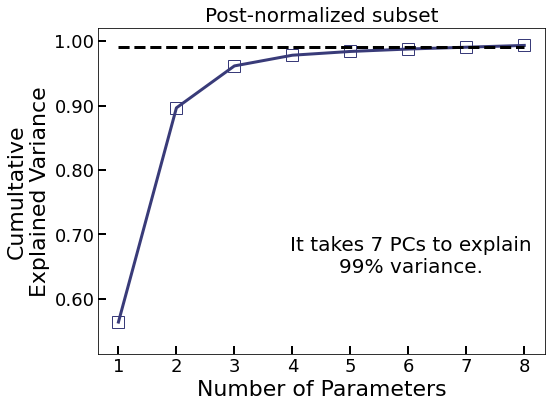

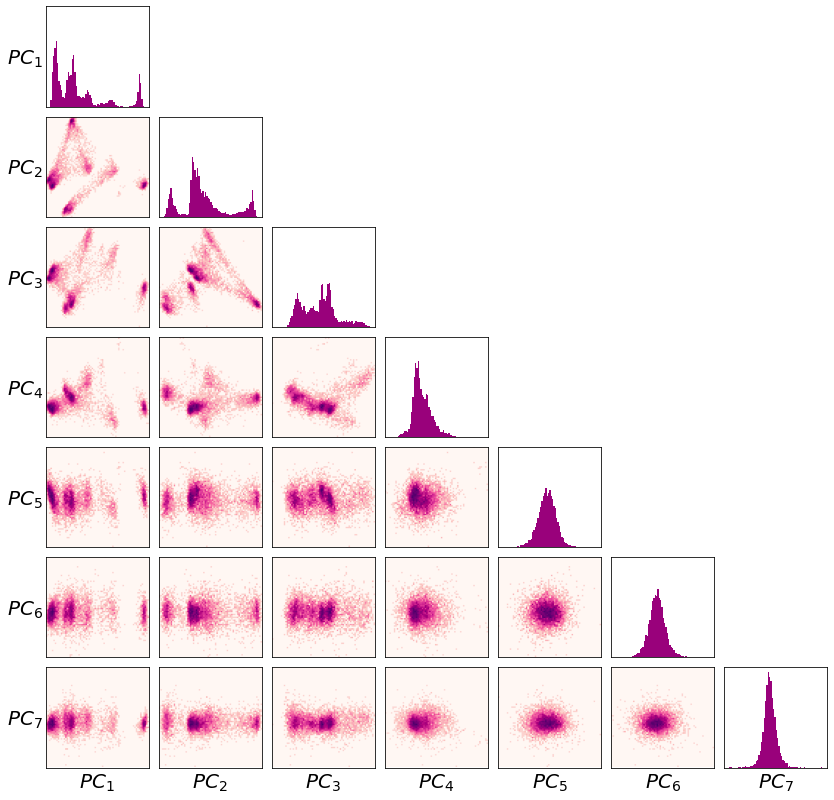

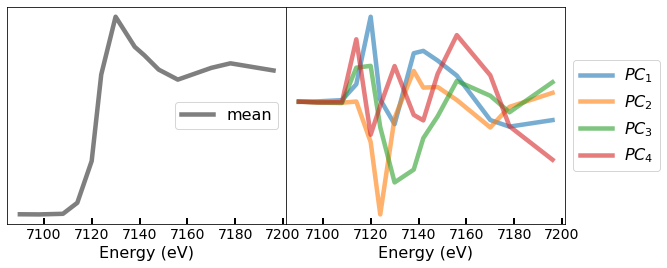

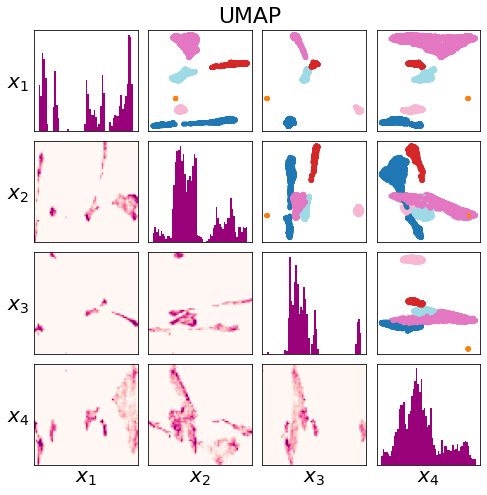

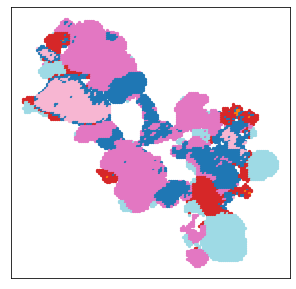

In [102]:
# PCA
n_components_sub = make_scree_plot(postnormalized_subset, n=8, c=0, threshold=0.99, show_first_PC=False)
plt.title('Post-normalized subset', fontsize=20)
plt.savefig('Figures/subset_scree.png', dpi=600, bbox_inches='tight')

pca, pca_components = make_PCA_triangle_plot(postnormalized_subset, n_components_sub, bins=70,
                                             cmap=plt.cm.RdPu, c=plt.cm.RdPu(0.8))
plt.savefig('Figures/subset_PCA_traingle_plot.png', dpi=600, bbox_inches='tight')

show_PCs(energy_subset, pca, n=4)
plt.savefig('Figures/subset_first_PCs.png', dpi=600, bbox_inches='tight')

# UMAP
color_labels_sub, codemap_sub, dbscan_clustering_sub = make_UMAP_plot(pca_components, normalized_spectra_dict,
                                                                      n_neighbors=20, min_dist=0, dimension=4,
                                                                      eps=1., bins=60, translation=4,
                                                                      cmap=plt.cm.RdPu, c=plt.cm.RdPu(0.8))
plt.savefig('Figures/subset_UMAP.png', dpi=600, bbox_inches='tight')

# Final Clusters
plot_color_code_map(plt.subplots(figsize=(5, 5)), normalized_spectra_dict, color_labels_sub)
plt.savefig('Figures/subset_cluster_map.png', dpi=600, bbox_inches='tight')

In [103]:
print(len(np.unique(dbscan_clustering_sub.labels_)))
print(len(np.unique(color_labels_sub)))

6
6


0 -> 12
3 -> 13
1 -> 6
2 -> 7
1 -> 19


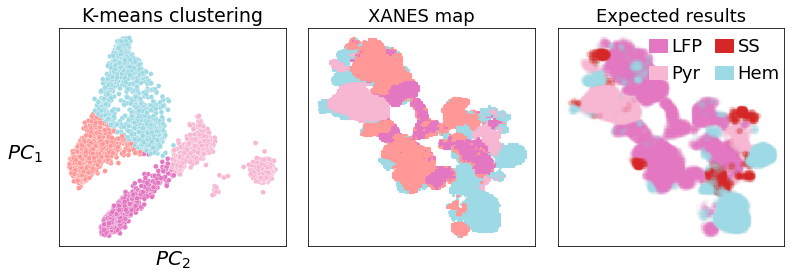

In [105]:
pca = PCA(n_components=2)
pca_components = pca.fit_transform(postnormalized_subset)

reduced_space = pca_components
spectra_dict = normalized_spectra_dict

clustering = KMeans(n_clusters=4, random_state=42).fit(reduced_space)
cluster_dict = {loc: clustering.labels_[i] for i, loc in enumerate(list(spectra_dict.keys()))}
color_labels, codemap = get_translated_colors(clustering, spectra_dict, map_colors=True,
                                              translation=2)
colors = [plt.cm.tab20(c) for c in color_labels]

fig, axes = plt.subplots(figsize=(13, 4), ncols=3)
plt.subplots_adjust(wspace=0.1)

ax = axes[0]
ax.scatter(reduced_space[:, 0], reduced_space[:, 1], marker='o', s=25, color=colors,
           edgecolor='w', linewidth=0.3)

ax.set_ylabel(f'$PC_1$', fontsize=20, loc="center", rotation="horizontal")
ax.yaxis.set_label_coords(-0.15, 0.37)
ax.set_xlabel(f'$PC_2$', fontsize=20)
ax.set_xticks([])
ax.set_yticks([])
ax.set_title('K-means clustering', fontsize=19)

plot_color_code_map((fig, axes[1]), normalized_spectra_dict, color_labels)
axes[1].set_title('XANES map', fontsize=18)

plot_expected_results(expected_results, axes[2])
axes[2].set_title('Expected results', fontsize=18)
plt.savefig('Figures/subset_PCA_kmeans_results.png', dpi=600, bbox_inches='tight')

## Step 3. LCF

In [106]:
clusters = {i: [] for i in np.unique(dbscan_clustering_sub.labels_)}

for i, key in enumerate(list(normalized_spectra_dict.keys())):
    spectrum = normalized_spectra_dict[key][indices]
    color = dbscan_clustering_sub.labels_[i]
    clusters[color].append(spectrum)

cluster_avgs = {key: np.average(clusters[key], axis=0) for key in list(clusters.keys())}

In [107]:
subset_size = 3 
subset_indices_sub, subsets_sub, scales_sub, coeffs_sub, scores_sub = [], [], [], [], []
targets = np.array(list(cluster_avgs.values()))
for i in range(len(targets)):
    sub_idxs, subset, scale, coeffs_hat, score = LCF(targets[i], Y_Refs, subset_size,
                                                     lambda1=1, lambda2=1e8)
    subset_indices_sub.append(sub_idxs)
    subsets_sub.append(subset)
    scales_sub.append(scale)
    coeffs_sub.append(coeffs_hat)
    scores_sub.append(score)

[3 5 7] 0.008024595403847257
[3 4 6] 0.002875755805955227
[ 1  7 10] 0.00022354083156428395
[1 4 9] 0.006146478224899776
[0 3 5] 0.008096881974931414
[ 2  9 10] 0.0004248753517394066


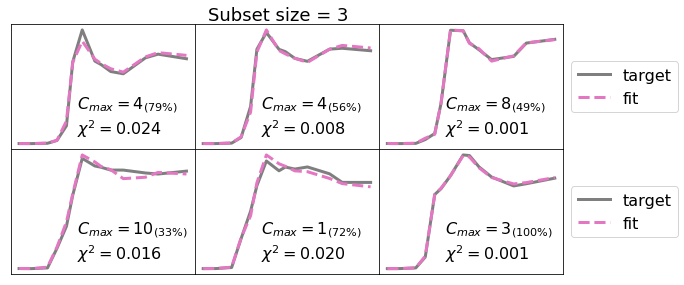

In [108]:
plot_recon_grid(energy_subset, targets, subset_indices_sub, subsets_sub, scales_sub, coeffs_sub, Refs_dict,
                ncols=3, flag_identity=False, c=6)              
plt.suptitle(f'Subset size = {subset_size}', fontsize=18, y=.88, va='bottom')
plt.show()

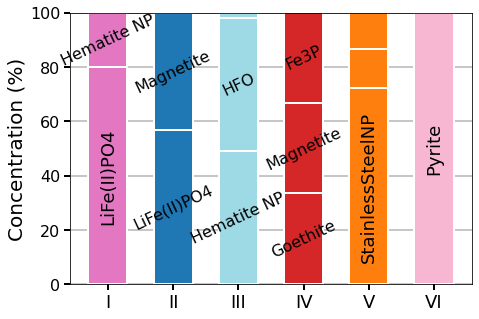

In [109]:
fig, ax = plt.subplots(figsize=(len(cluster_avgs) * 1.2, 5))
plot_conc_from_subset((fig, ax), np.array(coeffs_sub).reshape(len(coeffs_sub), -1),
                      list(Refs_dict.keys()), subset_indices_sub, codemap_sub)
plt.savefig('Figures/subset_cluster_concentrations.png', dpi=600, bbox_inches='tight')

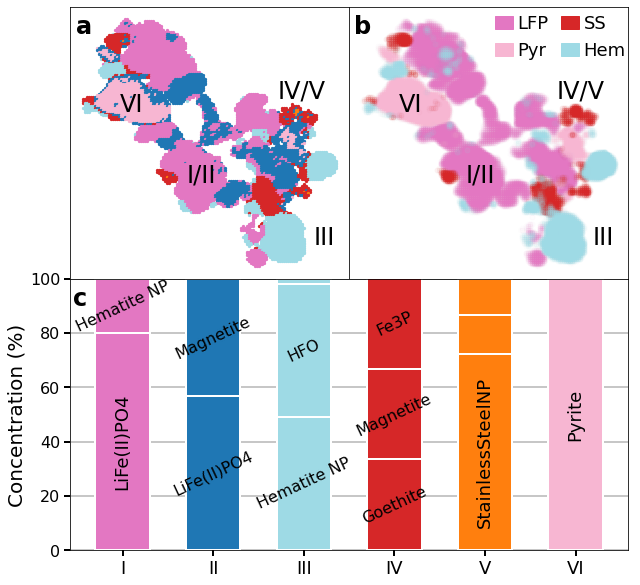

In [110]:
fig = plt.figure(figsize=(10, 10))
spec = fig.add_gridspec(nrows=2, ncols=2)
axes = [fig.add_subplot(spec[0, 0]), fig.add_subplot(spec[0, 1]),
        fig.add_subplot(spec[1, :])]
plt.subplots_adjust(hspace=0.0, wspace=0.0)

plot_color_code_map((fig, axes[0]), normalized_spectra_dict, color_labels_sub)

plot_expected_results(expected_results, axes[1])

plot_conc_from_subset((fig, axes[2]), np.array(coeffs_sub).reshape(len(coeffs_sub), -1),
                      list(Refs_dict.keys()), subset_indices_sub, codemap_sub)

panels = ['a', 'b', 'c']
for i, ax in enumerate(axes):
    if i == 2:
        x = 0.03
    else:
        x = 0.08
    ax.text(x, 0.97, panels[i], transform=ax.transAxes, fontweight='bold',
            fontsize=24, va='top', ha='right')
    
points = [(0.22, 0.64), (0.47, 0.38), (0.91, 0.15), (0.83, 0.69)]
labels = ['VI', 'I/II', 'III', 'IV/V']
for ax in axes[:2]:
    for i, pt in enumerate(points):
        x, y = pt
        ax.text(x, y, labels[i], transform=ax.transAxes,
                fontsize=24, va='center', ha='center')

plt.savefig('Figures/subset_results.png', dpi=600,
            transparent=True, bbox_inches='tight')

# Comparing both analyses

In [111]:
def get_cluster_conc(i, dbscan_clustering, subset_indices, N, coeffs):
    cluster = dbscan_clustering.labels_[i]
    concentrations = np.zeros(N)
    for j, index in enumerate(subset_indices[cluster]):
        concentrations[index] = coeffs[cluster, 0, j]
    return concentrations

In [112]:
scores = []
X1 = []
X2 = []
for i in range(len(normalized_spectra)):
    x1 = get_cluster_conc(i, dbscan_clustering, np.array(subset_indices),
                          Refs.shape[0], np.array(coeffs))
    x2 = get_cluster_conc(i, dbscan_clustering_sub, np.array(subset_indices_sub),
                          Y_Refs.shape[0], np.array(coeffs_sub))
    score = wasserstein_distance(x1, x2)
    scores.append(score)
    X1.append(x1)
    X2.append(x2)
scores = np.array(scores)
X1 = np.array(X1)
X2 = np.array(X2)
print(np.average(scores))

0.026922389028465676


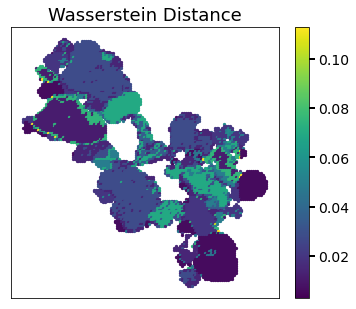

In [113]:
spectra_dict = normalized_spectra_dict
colors = [s / np.max(scores) + np.min(scores) for s in scores]
norm = mpl.colors.Normalize(vmin=np.min(scores), vmax=np.max(scores))

"""
intensities = np.max(filtered_spectra, axis=1)
norm = mpl.colors.Normalize(vmin=np.min(intensities), vmax=np.max(intensities))
intensities = [c / np.max(intensities) + np.min(intensities) for c in intensities]
intensities = np.array(intensities)
colors = intensities
"""

fig, ax = plt.subplots(figsize=(6, 5))
for i, key in enumerate(list(spectra_dict.keys())):
    spectrum = spectra_dict[key]
    x, y = key
    ax.plot(y, -x, marker='.', color=plt.cm.viridis(colors[i]), markersize=4.5)
remove_ticks(ax) 

cbar = plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=plt.cm.viridis))
cbar.ax.tick_params(direction='out', width=2, length=6, labelsize=14)
plt.title('Wasserstein Distance', fontsize=18)
plt.show()

# Analysis within clusters -- does LCF accuracy improve when filtering out for each cluster?

In [ ]:
utils = reload(utils)
from utils import *

In [ ]:
plot_color_code_map(normalized_spectra_dict, color_labels_sub, show_cluster=19)

In [ ]:
select_cluster = 19

sub_cluster_data = []
for i, key in enumerate(list(normalized_spectra_dict.keys())):
    spectrum = normalized_spectra_dict[key][indices]
    label = color_labels_sub[i]
    if label == select_cluster:
        sub_cluster_data.append(spectrum)
sub_cluster_data = np.array(sub_cluster_data)
print(sub_cluster_data.shape)

In [ ]:
subset_size = 3
subset_indices_sub, subsets_sub, scales_sub, coeffs_sub, scores_sub = [], [], [], [], []
targets = sub_cluster_data
for i in range(len(targets)):
    sub_idxs, subset, scale, coeffs_hat, score = LCF(targets[i], Y_Refs, subset_size,
                                                     lambda1=0.1, lambda2=1e8, verbose=False)
    subset_indices_sub.append(sub_idxs)
    subsets_sub.append(subset)
    scales_sub.append(scale)
    coeffs_sub.append(coeffs_hat)
    scores_sub.append(score)
    print(f'       {i}', end='\r')
    #if i == 100:
    #    break

In [ ]:
labels = np.max(np.array(subset_indices_sub), axis=1)
unique_labels = np.unique(labels)
ref_names = list(Refs_dict.keys())

select_cluster = 19
Colors = []
for c in unique_labels:
    print(f"looking for {c}")
    colors = []
    j = 0
    for i in range(len(normalized_spectra_dict)):
        cluster = color_labels_sub[i]
        if cluster == select_cluster:
            
            if j < len(labels):
                label = labels[j]
                if label == c:
                    colors.append(0)
                else:
                    colors.append(14)
            else:
                colors.append(select_cluster)
            
            j += 1
        
        else:
            colors.append(15)
    Colors.append(colors)
    
Colors = np.array(Colors)

In [ ]:
Colors.shape

In [ ]:
for c in range(len(unique_labels)):
    
    spectra_dict = normalized_spectra_dict
    colors = Colors[c]
    show_cluster = 19
    show_color = 0
    
    fig, ax = plt.subplots(figsize=(5, 5))
    for i, key in enumerate(list(spectra_dict.keys())):
        spectrum = spectra_dict[key]
        x, y = key
        if show_cluster == color_labels_sub[i]:
            if colors[i] == show_color:
                alpha = 1.0
                ms = 8
                zorder = 500000
            elif colors[i] == 14:
                alpha = 0.3
                ms = 4.5
                zorder = 1
            else:
                alpha = 0.9
                ms = 4.5
                zorder = 1
        else:
            alpha = 0.1
            ms = 4.5
            zorder = 1
        
        ax.plot(y, -x, color=plt.cm.tab20(colors[i]), marker='o', markersize=ms,
                alpha=alpha, zorder=zorder)
    remove_ticks(ax)
    
    plt.title(ref_names[c], fontsize=18)
    plt.show()